# For Issue 1279 | 311 Geospatial Analysis
---
Identify addresses or small areas that could benefit from more signage, increased community assistance, or other actions

# Package & Data Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# https://stackoverflow.com/questions/13440102/getting-bounding-box-of-city
import geopandas
from geopandas import GeoDataFrame, GeoSeries

# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
import folium
from branca.element import Figure
import re
import matplotlib
from folium.plugins import TimeSliderChoropleth

from titlecase import titlecase

%matplotlib inline
import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# 311 Data 10/01/2021-10/01/2022 from API see 01 notebook
raw_df = pd.read_csv('./data/clean_01Oct21_01Oct22_api.csv')
df = raw_df.copy()

# https://geopandas.org/en/stable/getting_started/introduction.html
# NC boundaries: https://data.lacity.org/City-Infrastructure-Service-Requests/Neighborhood-Councils-Certified-/fu65-dz2f
raw_gdf_nc = geopandas.read_file('./data/Neighborhood Councils (Certified)/geo_export_88bb18d9-f96c-4351-8be9-594f258ed0d3.shp')
gdf_nc = raw_gdf_nc.copy()

# Block boundaries: https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/06_CALIFORNIA/06037/
# tl_2020_06037_tabblock20.zip
raw_gdf_blk = geopandas.read_file("./data/tl_2020_06037_tabblock20/tl_2020_06037_tabblock20.shp")
gdf_blk = raw_gdf_blk.copy()

In [3]:
print(df.shape)
df.head(1)

(1042208, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima


In [4]:
print(gdf_nc.shape)
gdf_nc.head(1)

(99, 9)


,date_certi,time_certi,dwebsite,name,nc_id,objectid,service_re,waddress,geometry
0,2002-10-22,00:00:00.000,http://empowerla.org/ANC,ARLETA NC,6.0,1.0,REGION 1 - NORTH EAST VALLEY,http://www.arletanc.org/,"POLYGON ((-118.45005 34.24992, -118.45055 34.2..."


In [5]:
print(gdf_blk.shape)
gdf_blk.head(1)

(91626, 16)


,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,06,037,109300,2015,060371093002015,Block 2015,G5040,None,None,None,S,17913,0,+34.2673969,-118.4797070,"POLYGON ((-118.48022 34.26741, -118.48021 34.2..."


# Data Cleaning
---

In [4]:
# to datetime
df['createdDate'] = pd.to_datetime(df['createdDate'])
df['closedDate'] = pd.to_datetime(df['closedDate'])

print(df.shape)
df.head()

(1042208, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima
2,8610575,2021-10-01 00:03:11,2021-10-13 12:31:58,4,Bulky Items,"4539 N VISTA DEL MONTE AVE, 91403","(34.1541582469, -118.450024901)",34.154158,-118.450025,3,Sanitation Bureau,8,1-2079512561,Phone Call,72,Sherman Oaks
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012","(34.066466398, -118.245112635)",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima


In [5]:
# get necessary columns; objectid = councilId
gdf = gdf[['name', 'nc_id', 'objectid', 'service_re', 'geometry']].sort_values(by = 'nc_id').reset_index(drop = True)

# format data
gdf['name'] = gdf['name'].apply(lambda x: titlecase(x.strip(' NC')))
gdf['service_re'] = gdf['service_re'].apply(lambda x: titlecase(x))
gdf['nc_id'] = gdf['nc_id'].apply(lambda x: int(x))
gdf['objectid'] = gdf['objectid'].apply(lambda x: int(x))

print(gdf.shape)
gdf.head()

(99, 5)


,name,nc_id,objectid,service_re,geometry
0,Granada Hills North,4,27,Region 2 - North West Valley,"POLYGON ((-118.50737 34.33461, -118.50570 34.3..."
1,Sylmar,5,79,Region 1 - North East Valley,"POLYGON ((-118.50737 34.33461, -118.50380 34.3..."
2,Arleta,6,1,Region 1 - North East Valley,"POLYGON ((-118.45005 34.24992, -118.45055 34.2..."
3,Pacoima,7,63,Region 1 - North East Valley,"POLYGON ((-118.41566 34.29392, -118.40815 34.2..."
4,Sun Valley Area,8,77,Region 1 - North East Valley,"POLYGON ((-118.36516 34.22933, -118.36400 34.2..."


## Checking Consistency Between gdf and df
#### To Note:
- df['councilID'] == gdf['objectiid']
- df contains a 0 ID for No Council

In [6]:
print(f"Number of Council Names in gdf: {len(gdf['name'].unique())}")
print(f"Number of Council Names in df: {len(df['councilName'].unique())}")
print(f"Number of Council # in gdf: {len(gdf['objectid'].unique())}")
print(f"Number of Council # in df: {len(df['councilId'].unique())}")

Number of Council Names in gdf: 99
Number of Council Names in df: 100
Number of Council # in gdf: 99
Number of Council # in df: 100


In [7]:
df[df['councilName'] == 'Glassell Park'].head(1)

,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
368,8613495,2021-10-01 08:57:03,2021-10-01 10:45:28,1,Graffiti,"3301 N DIVISION ST, 90065","(34.104948487, -118.230960808)",34.104948,-118.230961,4,Office of Community Beautification,7,1-2079661771,Mobile App,26,Glassell Park


In [8]:
gdf[gdf['name'] == 'Glassell Park']

,name,nc_id,objectid,service_re,geometry
32,Glassell Park,39,26,Region 8 - North East La,"POLYGON ((-118.25412 34.11885, -118.25113 34.1..."


In [9]:
print(f"Council #'s in gdf: {sorted([nc for nc in gdf['objectid'].unique()])}")
print()
print(f"Council #'s in df: {sorted([nc for nc in df['councilId'].unique()])}")

Council #'s in gdf: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Council #'s in df: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [10]:
gdf[gdf['objectid'] == 1]

,name,nc_id,objectid,service_re,geometry
2,Arleta,6,1,Region 1 - North East Valley,"POLYGON ((-118.45005 34.24992, -118.45055 34.2..."


In [11]:
df[df['councilId'] == 1].head(1)

,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
79,8611807,2021-10-01 07:02:54,2021-10-01 07:13:41,1,Graffiti,"9460 N ARLETA AVE, 91331","(34.2418237684, -118.425641134)",34.241824,-118.425641,4,Office of Community Beautification,18,1-2079561351,Work Crew,1,Arleta


# Geospatial Variable Creation
---

In [12]:
gdf = gdf[['geometry', 'objectid']]
df = df[['requestId', 'createdDate', 'councilId', 'latitude', 'longitude']].sort_values(by = 'createdDate')

In [13]:
gdf.head()

,geometry,objectid
0,"POLYGON ((-118.50737 34.33461, -118.50570 34.3...",27
1,"POLYGON ((-118.50737 34.33461, -118.50380 34.3...",79
2,"POLYGON ((-118.45005 34.24992, -118.45055 34.2...",1
3,"POLYGON ((-118.41566 34.29392, -118.40815 34.2...",63
4,"POLYGON ((-118.36516 34.22933, -118.36400 34.2...",77


In [14]:
df.head()

,requestId,createdDate,councilId,latitude,longitude
0,8610592,2021-10-01 00:01:14,64,34.281312,-118.425453
1,8610569,2021-10-01 00:02:19,64,34.281312,-118.425453
2,8610575,2021-10-01 00:03:11,72,34.154158,-118.450025
3,8612855,2021-10-01 00:04:14,38,34.066466,-118.245113
4,8610587,2021-10-01 00:05:25,64,34.281312,-118.425453


In [15]:
# create df of running count of requests per neighborhood council
df_ct = df.groupby(['createdDate','councilId', 'latitude', 'longitude'])['requestId'].agg('count').reset_index(name = 'request_ct')
df_ct['nc_running_ct'] = df_ct.groupby('councilId')['request_ct'].cumsum()

# add color variable for mapping
# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
bins=np.linspace(min(df_ct['nc_running_ct']),max(df_ct['nc_running_ct']),11)
df_ct['color']=pd.cut(df_ct['nc_running_ct'],bins,labels=['#FFEBEB','#F8D2D4','#F2B9BE','#EBA1A8','#E58892','#DE6F7C','#D85766','#D13E50','#CB253A','#C50D24'],include_lowest=True)
df_ct_plt = df_ct[['createdDate', 'color', 'councilId']]
df_ct_plt.head()

,createdDate,color,councilId
0,2021-10-01 00:01:14,#FFEBEB,64
1,2021-10-01 00:02:19,#FFEBEB,64
2,2021-10-01 00:03:11,#FFEBEB,72
3,2021-10-01 00:04:14,#FFEBEB,38
4,2021-10-01 00:05:25,#FFEBEB,64


In [16]:
# TimeSliderCloropleth
# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
# convert datetime to TimeSliderCloropleth accepted format
df_ct_plt['createdDate'] = (df_ct_plt['createdDate'].astype(int)// 10**9).astype('U10')
df_ct_plt['createdDate'] = df_ct_plt['createdDate'].apply(lambda x: int(x))

# create dictionary for TimeSliderCloropleth
df_dict={}
for i in df_ct_plt['councilId'].unique():
    df_dict[i]={}
    for j in df_ct_plt[df_ct_plt['councilId']==i].set_index(['councilId']).values:   
        df_dict[i][j[0]]={'color':j[1],'opacity':0.7}

In [17]:
# list(df_dict.items())[1]

# Geospatial Basemapping
---

In [18]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

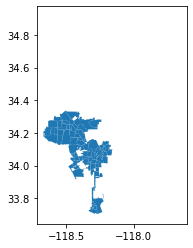

In [19]:
gdf.plot()

In [20]:
# Basemap
# gdf to json string for plot
gdf_plt = gdf.to_json()

fig = Figure(height = 850, width = 1000)
m = folium.Map(location = (34, -118), tiles='cartodbpositron', zoom_start=10)
fig.add_child(m)

# TimeSliderCloropleth
g = TimeSliderChoropleth(
    gdf_plt,
    styledict = df_dict
).add_to(m)
m

TypeError: keys must be str, int, float, bool or None, not numpy.int64

In [21]:
# Basemap TESTING
fig = Figure(width=550,height=350)
m1=folium.Map(width=550,height=350,location=[28.644800, 77.216721],zoom_start=11,min_zoom=8,max_zoom=14)
fig.add_child(m1)

# Add tiles
folium.TileLayer('Stamen Terrain').add_to(m1)
folium.LayerControl().add_to(m1)

# Add Markers
folium.Marker(location=[28.695800, 77.244721],popup='Default popup Marker1',tooltip='Click here to see Popup').add_to(m1)
folium.Marker(location=[28.645800, 77.214721],popup='<strong>Marker3</strong>',tooltip='<strong>Click here to see Popup</strong>').add_to(m1)
folium.Marker(location=[28.655800, 77.274721],popup='<h3 style="color:green;">Marker2</h3>',tooltip='<strong>Click here to see Popup</strong>').add_to(m1)

m1